In [1]:
import numpy as np
# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Set rcParams
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.integrate

In [3]:
from tqdm import tnrange

In [107]:
import matplotlib.colors
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Define set of idealized timers

In [13]:
T = 0.2
dt = 1e-4
tt = np.arange(0, int(T/dt))*dt

timers = np.zeros((6, len(tt)))
centers = np.arange(0, 6)*T/5
for i in range(6):
    timers[i,:] = np.exp(-(tt-centers[i])**2/(2*0.015**2))

## Ext. fig. 4a

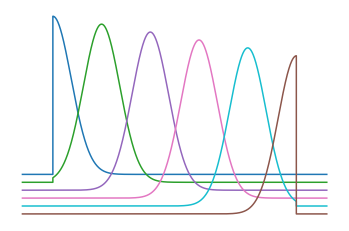

In [14]:
colors = ['C0', 'C2', 'C4', 'C6', 'C9', 'C5', 'C8']
tt_aug = np.concatenate((np.array([-0.025,0]), tt, np.array([0,0.025])+tt[-1]))
for i in range(6):
    plt.plot(tt_aug, -0.05*i+np.concatenate((np.array([0,0]), timers[i,:], np.array([0,0]))), c=colors[i])
plt.axis('off');

## Define distribution of PF/CF intervals

In [11]:
distr = np.exp(-(tt-0.08)**2/(2*0.05**2))

In [74]:
cdf = np.cumsum(distr/np.sum(distr))

get_interval = lambda r: np.interp(r, cdf, tt)
get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)

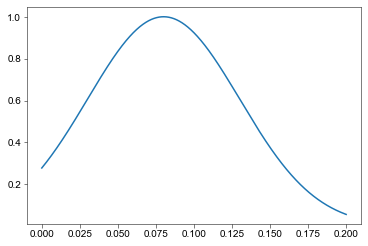

In [12]:
plt.plot(tt, distr)

# Fixed updates

In [15]:
# Function to pass to ODE solver for implementation of fixed update method
def fixedUpdatesBiochem(t, y, CF_on, increase_index, k_c_plus=50, k_c_minus=1):
    # CF_on = True during duration of CF spike
    # increase_index = index of most active timer at time of CF spike
    
    # k_c_plus = 50 # 10
    # k_c_minus = 1 # 0.2
    theta_c_plus = 1e-3
    theta_c_minus = 1e-3

    dydt = np.zeros(len(y))
    for i in range(1,len(y)):
        if i == increase_index+1:
            dydt[i] = k_c_plus*y[0]*(1-y[i])/(theta_c_plus+1-y[i])
        elif CF_on:
            dydt[i] = -k_c_minus*y[i]/(theta_c_minus+y[i])
    dydt[0] = -np.sum(dydt[1:])
    return dydt

## Plot example dynamics (Ext fig. 4b)

In [75]:
# Set initial condition for coupling weight values
couplings_pre = np.array([1,2,3,4,5,6])
s = np.sum(couplings_pre)
couplings_pre = couplings_pre/s

In [71]:
# Pick random PF/CF intervals from distribution, and determine
# which timer is most active at each time
inds = np.zeros(5, dtype=int)
for i in range(len(inds)):
    inds[i] = np.argmax(timers[:, get_interval_NN(np.random.rand())])

In [72]:
# Simulate 5 PF/CF pairings
y0 = np.concatenate((np.array([0]), couplings_pre))

t_total = np.array([])
y_total = np.array([])
for i in range(5):
    # Simulate CF spike (10 ms duration)
    sol_on = scipy.integrate.solve_ivp(lambda t,y: fixedUpdatesBiochem(t, y, True, inds[i]), (0, 0.01), y0)
    # Allow dynamics to continue after CF spike is over (for 190 ms, time arbitrary)
    sol_off = scipy.integrate.solve_ivp(lambda t,y: fixedUpdatesBiochem(t, y, False, inds[i]), (0, 0.19), sol_on.y[:,-1])
    
    y0 = sol_off.y[:,-1]
    if len(t_total) == 0:
        t_total = np.concatenate((sol_on.t, sol_off.t+sol_on.t[-1]))
        y_total = np.hstack((sol_on.y, sol_off.y))
    else:
        t_total = np.concatenate((t_total, sol_on.t+t_total[-1], sol_off.t+sol_on.t[-1]+t_total[-1]))
        y_total = np.hstack((y_total, sol_on.y, sol_off.y))


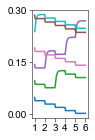

In [84]:
# Plot coupling weights
plt.figure(figsize=(1, 2))
colors = ['C0', 'C2', 'C4', 'C6', 'C9', 'C5', 'C8']

for i in range(1,7):
    plt.plot(t_total, y_total[i,:], c=colors[i-1], clip_on=False);

plt.xticks(np.arange(0, 6)*0.2, np.arange(1,7));
plt.yticks([0, 0.15, 0.3]);

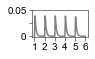

In [51]:
# Concentration of limited resource
plt.figure(figsize=(1,0.5))
plt.plot(t_total, y_total[0,:], c=(0.5, 0.5, 0.5))
plt.xticks(np.arange(0, 6)*0.2, np.arange(1,7));
plt.yticks([0, 0.025, 0.05], [0,'', 0.05]);

## Simulate ATTRAP using fixed upates

In [90]:
def selectionFixedBiochem(v_initial, distr, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism, using
    biochemical implementation.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    get_interval = lambda r: np.interp(r, cdf, tt)
    get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    y0 = np.concatenate((np.array([0]), np.copy(v)))
    for it in tnrange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        timer_vals = timers[:,get_interval_NN(np.random.rand())]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)

        sol_on = scipy.integrate.solve_ivp(lambda t,y: fixedUpdatesBiochem(t, y, True, active_timer, k_c_plus=10, k_c_minus=0.2 ), (0, 0.01), y0)
        sol_off = scipy.integrate.solve_ivp(lambda t,y: fixedUpdatesBiochem(t, y, False, active_timer, k_c_plus=10, k_c_minus=0.2 ), (0, 0.2), sol_on.y[:,-1])

        y0 = sol_off.y[:,-1]
        v = np.copy(y0[1:])

        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [ ]:
N_sims = 10
v_finals_fixed = np.zeros((6, N_sims))
v_fixed_peak = np.zeros((N_sims, 10000))
for n in tnrange(N_sims):
    v0 = np.array([1, 0, 0, 0, 0,0])
    v_final_fixed, v_fixed = selectionFixedBiochem(v0, distr, its=10000, report_its=1)
    v_finals_fixed[:,n] = v_final_fixed
    v_fixed_peak[n,:] = v_fixed[2,:]

## Example eligibility after ATTRAP (Ext. fig. 4b)

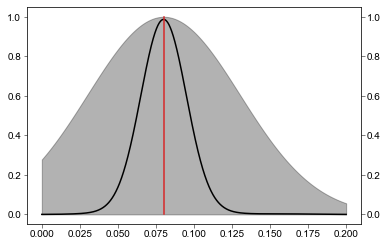

In [96]:
plt.fill_between(tt, 0, distr, color='k', alpha=0.3)
ax = plt.twinx()
plt.plot(tt, v_final_fixed@timers, c='k')
plt.plot([0.08,]*2, [0,1], c='C3');

In [97]:
v_fixed_peak_mu = np.mean(v_fixed_peak, axis=0)
v_fixed_peak_std = np.std(v_fixed_peak, axis=0)

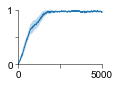

In [99]:
plt.figure(figsize=(1.5, 1))

it_inds = np.arange(5000)

plt.plot(it_inds, v_fixed_peak_mu[:5000], lw=1, clip_on=False)
plt.fill_between(it_inds, v_fixed_peak_mu[:5000] - v_fixed_peak_std[:5000], 
                 v_fixed_peak_mu[:5000] + v_fixed_peak_std[:5000], 
                 alpha=0.3, clip_on=False)

plt.yticks([0, 0.5, 1], [0, '', 1]);
plt.xticks([0, 2500, 5000], [0, '', 5000])

plt.ylim([0, 1])
plt.xlim([0, 5000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

# Proportional updates

In [76]:
def proportionalUpdatesBiochem(t, y, CF_on, increase_index, k_c_plus = 1, k_c_minus = 1):
    # k_c_plus = 1 # 0.1
    # k_c_minus = 1 # 0.1
    
    num_states = len(y)
    dydt = np.zeros(len(y))
    for i in range(len(y)):
        if CF_on:
            if i == increase_index:
                dydt[i] = k_c_plus*(1-y[i])
            else:
                dydt[i] = -k_c_minus*y[i]
    return dydt

## Plot example dynamics (Ext. fig. 4c)

In [78]:
y0 = couplings_pre

t_total_soft = np.array([])
y_total_soft = np.array([])
for i in range(5):
    # Simulate CF spike (duration 10 ms)
    sol_on = scipy.integrate.solve_ivp(lambda t,y: proportionalUpdatesBiochem(t, y, True, inds[i]), (0, 0.01), y0)
    # Continue dynamics after CF spike offset
    sol_off = scipy.integrate.solve_ivp(lambda t,y: proportionalUpdatesBiochem(t, y, False, inds[i]), (0, 0.19), sol_on.y[:,-1])
    
    y0 = sol_off.y[:,-1]
    if len(t_total_soft) == 0:
        t_total_soft = np.concatenate((sol_on.t, sol_off.t+sol_on.t[-1]))
        y_total_soft = np.hstack((sol_on.y, sol_off.y))
    else:
        t_total_soft = np.concatenate((t_total_soft, sol_on.t+t_total_soft[-1], sol_off.t+sol_on.t[-1]+t_total_soft[-1]))
        y_total_soft = np.hstack((y_total_soft, sol_on.y, sol_off.y))

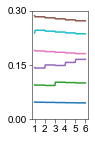

In [85]:
plt.figure(figsize=(1, 2))
colors = ['C0', 'C2', 'C4', 'C6', 'C9', 'C5', 'C8']

for i in range(0,6):
    plt.plot(t_total_soft, y_total_soft[i,:], c=colors[i], clip_on=False);

plt.xticks(np.arange(0, 6)*0.2, np.arange(1,7));
plt.yticks([0, 0.15, 0.3]);

## Simulate ATTRAP using proportional updates

In [101]:
def selectionProportionalBiochem(v_initial, distr, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism
    using biochemcial implementation.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    get_interval = lambda r: np.interp(r, cdf, tt)
    get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    for it in tnrange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        timer_vals = timers[:,get_interval_NN(np.random.rand())]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)
        
        # Update weights
        sol_on = scipy.integrate.solve_ivp(lambda t,y: proportionalUpdatesBiochem(t, y, True, active_timer, k_c_plus=0.1, k_c_minus=0.1), (0, 0.01), v)
        sol_off = scipy.integrate.solve_ivp(lambda t,y: proportionalUpdatesBiochem(t, y, False, active_timer, k_c_plus=0.1, k_c_minus=0.1), (0, 0.2), sol_on.y[:,-1])

        v = np.copy(sol_off.y[:,-1])
        
        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

In [ ]:
v0 = np.array([1, 0, 0, 0, 0, 0])
v_final_proportional, v_proportional_all = selectionProportionalBiochem(v0, distr, its=100000, report_its=100)

## Extended fig. 4c

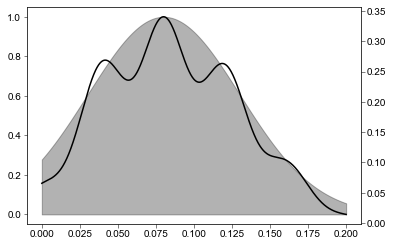

In [110]:
plt.fill_between(tt, 0, distr, alpha=0.3, color='k')
ax = plt.twinx()
plt.plot(tt, v_final_proportional@timers, c='k');

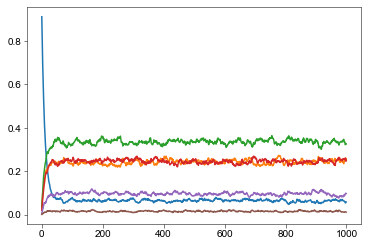

In [109]:
# Evolution of coupling weights as a function of PF/CF pair presentation
plt.plot(np.arange(v_proportional_all.shape[1]), v_proportional_all.T);